In [14]:
import numpy as np
import plotly.graph_objs as pgo # For Plotting isosurfaces
import matplotlib.pyplot as plt # For other plotting

In [15]:
# Load in and reshape data
sub_data = np.load('./subdata.npy') # Loads in flattened array of 3D data
sub_data.shape

(262144, 49)

In [16]:
# Define Normal Space Parameters
L = 10 # Length of side
N = 64 # Size of grid in each direction
x = np.linspace(-L, L, N+1) # spatial x grid
x = x[:-1] # Take first N points
y = x; z = x # Same discretation in other dimensions
x_grid, y_grid, z_grid = np.meshgrid(x, y, z) # Generate meshgrid

In [17]:
# Define Fourier Space Parameters
# NOTE: Take out -1 from fourier vector as numpy doesn't include upper endpoint
kx = 2 * np.pi/(2 * L) * np.hstack((np.arange(0, N/2), np.arange(-N/2, 0))) # Define base kx vector, fourier order
kx = np.fft.fftshift(kx) # Apply fftshift for proper order of items
ky = kx; kz = kx # Same fourier discretation in all dimensions
kx_grid, ky_grid, kz_grid = np.meshgrid(kx, ky, kz)

In [18]:
# Calculate FFT of each time step
sub_data_fft = np.zeros((N, N, N, sub_data.shape[1]), dtype='complex_') # Need to allow for complex values
for i in range(sub_data.shape[1]): # Iterate through all 3D slices
    sub_signal = np.reshape(sub_data[:, i], (N, N, N), 'F')
    sub_signal_fft = np.fft.fftn(sub_signal)
    sub_data_fft[:,:,:,i] = np.fft.fftshift(sub_signal_fft) # Add each element to result

In [19]:
# Average data to remove noise
sub_data_fft_sum = np.sum(sub_data_fft, axis=3) # Sum across last axis
average_frequencies = np.abs(sub_data_fft_sum) / np.abs(sub_data_fft_sum.flatten()).max() # Normalize frequencies

In [20]:
# Get location of max frequency
max_idx = np.argmax(average_frequencies.flatten())
x_loc, y_loc, z_loc = np.unravel_index(max_idx, sub_data_fft_sum.shape) # Linear index to matrix form (column major)
x_freq = kx_grid[x_loc, y_loc, z_loc].flatten() # Extract x frequency(ies)
y_freq = ky_grid[x_loc, y_loc, z_loc].flatten() # Extract y frequency(ies)
z_freq = kz_grid[x_loc, y_loc, z_loc].flatten() # Extract z frequency(ies)
print(x_freq, y_freq, z_freq)

[-5.34070751] [6.91150384] [-2.19911486]


In [21]:
# Create Gaussian Filter using central frequency
gauss_filt = np.exp(-0.1 * ((kx_grid - x_freq[0])**2  + (ky_grid - y_freq[0])**2 + (kz_grid - z_freq[0])**2))

In [22]:
# Use Gaussian filter to de-noise and locate the data
position_data = np.zeros((sub_data.shape[1], 3)) # For storing locations
for i in range(sub_data.shape[1]): # Iterate through data
    sub_loc_fft = sub_data_fft[:, :, :, i] # Access the FFT data (already shifted)
    sub_loc_fft_filt = sub_loc_fft * gauss_filt # Apply filter
    sub_loc_fft_filt = np.fft.ifftshift(sub_loc_fft_filt) # Shift data back
    sub_loc_filt = np.fft.ifftn(sub_loc_fft_filt) # inverse transform
    sub_loc_norm = np.abs(sub_loc_filt) / np.abs(sub_loc_filt.flatten()).max()
    main_frequency = np.argmax(sub_loc_norm.flatten()) # Find flattened index of main
    x_loc, y_loc, z_loc = np.unravel_index(main_frequency, sub_loc_norm.shape) # Get indexes
    x_loc, y_loc, z_loc = x_grid[x_loc, y_loc, z_loc], y_grid[x_loc, y_loc, z_loc], z_grid[x_loc, y_loc, z_loc] # Get locations
    position_data[i, :] = [x_loc, y_loc, z_loc] # Append

print(position_data)

[[ 3.125   0.     -8.125 ]
 [ 3.125   0.3125 -7.8125]
 [ 3.125   0.625  -7.5   ]
 [ 3.125   0.9375 -7.1875]
 [ 3.125   1.5625 -6.875 ]
 [ 3.125   1.875  -6.5625]
 [ 3.125   2.1875 -6.25  ]
 [ 3.125   2.5    -5.9375]
 [ 3.125   2.8125 -5.625 ]
 [ 2.8125  3.125  -5.3125]
 [ 2.8125  3.4375 -5.    ]
 [ 2.5     3.75   -4.6875]
 [ 2.1875  4.0625 -4.375 ]
 [ 1.875   4.375  -4.0625]
 [ 1.875   4.6875 -3.75  ]
 [ 1.5625  5.     -3.4375]
 [ 0.9375  5.     -3.125 ]
 [ 0.625   5.     -2.8125]
 [ 0.3125  5.3125 -2.5   ]
 [ 0.      5.625  -2.1875]
 [-0.625   5.625  -1.875 ]
 [-0.9375  5.625  -1.5625]
 [-1.25    5.9375 -1.25  ]
 [-1.875   5.9375 -1.25  ]
 [-2.1875  5.9375 -0.9375]
 [-2.8125  5.9375 -0.625 ]
 [-3.125   5.9375 -0.3125]
 [-3.75    5.9375  0.    ]
 [-4.0625  5.9375  0.3125]
 [-4.375   5.9375  0.625 ]
 [-4.6875  5.625   0.9375]
 [-5.3125  5.625   1.25  ]
 [-5.625   5.3125  1.5625]
 [-5.9375  5.3125  1.875 ]
 [-5.9375  5.      2.1875]
 [-6.25    5.      2.5   ]
 [-6.5625  4.6875  2.8125]
 

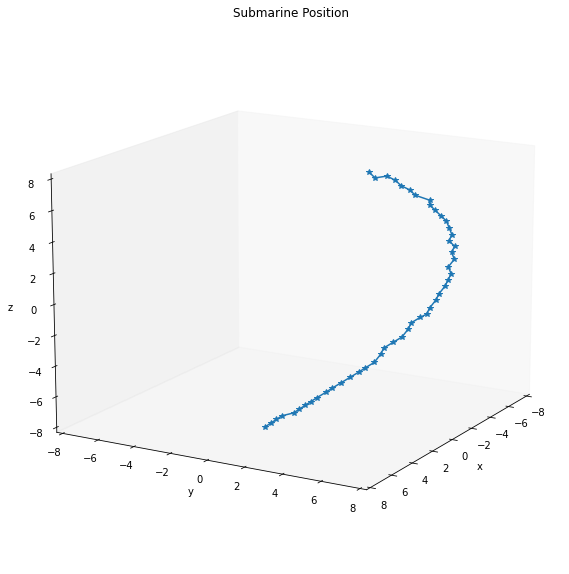

In [35]:
# Plot 3D Position
fig = plt.figure(figsize=(10,10)) # Generate subplots

# 3D Position Plot
ax0 = plt.axes(projection='3d'); ax0.grid(False)
ax0.plot(position_data[:, 0], position_data[:, 1], position_data[:, 2], '-*')
ax0.set_xlim(-8, 8); ax0.set_ylim(-8, 8); ax0.set_zlim(-8, 8)
ax0.set_xlabel('x'); ax0.set_ylabel('y'); ax0.set_zlabel('z')
ax0.set_title('Submarine Position')
ax0.view_init(15,30)

Text(0.5, 1.0, 'Submarine Position: x, y')

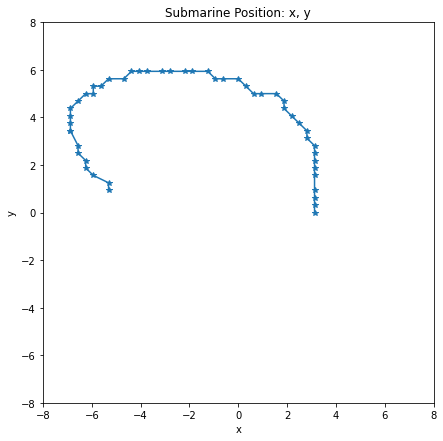

In [26]:
# X, Y plot
fig = plt.figure(figsize=(7, 7))
plt.plot(position_data[:, 0], position_data[:, 1], '-*')
plt.xlim(-8, 8); plt.ylim(-8, 8);
plt.xlabel('x'); plt.ylabel('y');
plt.title('Submarine Position: x, y')